import

In [158]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data.sampler import RandomSampler, SequentialSampler
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from matplotlib import gridspec
import pickle as pkl
import itertools
import matplotlib.pyplot as plt
import sys, os
opj = os.path.join
ope = os.path.exists
this_dir = os.getcwd()
lib_paths = [opj(this_dir, 'bestfitting/protein_clean/src'), opj(this_dir, 'CD'), opj(this_dir, 'viz')]
for lib_path in lib_paths:
    if lib_path not in sys.path:
        sys.path.insert(0, lib_path) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
from cd_propagate import *
from cd import *
from dset import *
from score_funcs import *
import viz 
from config.config import * # set directory paths (DATA_DIR, RESULT_DIR etc) 
import train_cls_net # import Protein class
from net.loss_funcs.kaggle_metric import prob_to_result # import prob_to_result
from net.loss_funcs.kaggle_metric import get_probs_f1_score # import get_probs_f1_score  
import warnings
warnings.filterwarnings("ignore")

### Set parameters and directories

In [160]:
# get args
args = get_args()

# set dirs
# fname=which file to evaluate
dir_args, data_args = set_dirs(args, fname='valid_160.csv')

# get Protein class
trainer = train_cls_net.Protein(dir_args,
                                train_batch_size=args.train_batch_size,
                                test_batch_size=args.test_batch_size,
                                seed=args.seed, img_size=args.img_size,in_channels=args.in_channels,
                                save_probs=args.save_probs,
                                aug_version=args.aug_version,
                                num_classes=args.num_classes,
                                crop_size=args.crop_size,
                                clipnorm=args.clipnorm)

# load model
net, scheduler, loss = load_densenet_pretrained(args, trainer, data_args)

# test dataset and dataloader
test_dataset = get_dataset(trainer)
test_loader = protein_dataset.DataLoader(test_dataset,
                                         sampler=SequentialSampler(test_dataset),
                                         batch_size=trainer.test_batch_size,
                                         drop_last=False,
                                         num_workers=trainer.num_workers,
                                         pin_memory=True)

in_channels 4
load model file from: /home/ubuntu/HPA/hpa_interp/bestfitting/protein_clean/result/models/external_crop1024_focal_slov_hardlog_clean_class_densenet121_large_dropout_i1536_aug2_5folds/fold0/final.pth
using gpu 0
/home/ubuntu/HPA/hpa_interp/bestfitting/protein_clean/data/train/images_1536
/home/ubuntu/HPA/hpa_interp/bestfitting/protein_clean/data/train/external_v18_1536


In [161]:
# use gpu
if trainer.gpu_flag:
    net.cuda()
# net eval mode
net.eval()

print('ready to evaluate')

ready to evaluate


### CD score

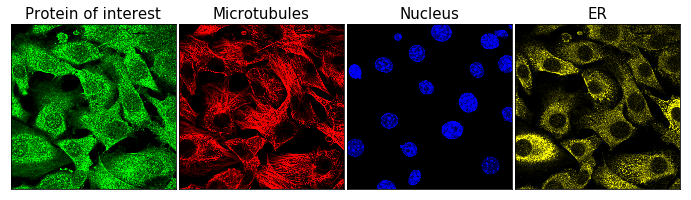

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0]])


In [162]:
from cd_propagate import *
# load test image
load_img = pkl.load(open('./data/test_image', 'rb'))
test_image = load_img['image']
test_label = load_img['label']

# viz test image
img_index = 0
viz.viz_channels_separate(test_image, img_index)
print(test_label)

In [163]:
# switch dtype
dtype = torch.float
im = test_image.clone().detach().type(dtype)
net.float() if dtype==torch.float else net.double()
print('switch to', dtype)

switch to torch.float32


In [164]:
# middle layer feature
output, outputs = forward_pass(im, net)
layer_ind = 9
feature_map = outputs[layer_ind].clone()

# relevant scores
img_size = 16
superpixel_size = 1 # superpixel size
h_num, w_num = int(img_size/superpixel_size), int(img_size/superpixel_size)

rel_scores = torch.zeros(len(test_image), img_size, img_size, NUM_CLASSES, dtype=dtype)

In [165]:
accuracy = []

with torch.no_grad():
    for h, w in itertools.product(range(h_num), range(w_num)):  
        # set up masks
        mask = torch.zeros(feature_map.size(), dtype=dtype)
        mask[:,:,h*superpixel_size:(h+1)*superpixel_size,w*superpixel_size:(w+1)*superpixel_size] = 1        

        relevant, irrelevant, _ = cd_middle_layer(feature_map, net, mask)
        
        accuracy.append(torch.norm(relevant + irrelevant - output))
        if accuracy[-1] > 1e-3:
            print('sum of cd scores do not match the original ouput at (height,width) =', (h,w))
        if torch.isnan(accuracy[-1]).sum().item() >= 1:
            print('Nan occured')

        rel_scores[:,h*superpixel_size:(h+1)*superpixel_size, 
                        w*superpixel_size:(w+1)*superpixel_size,:] = relevant

        print('\r iterations (height,width) =', (h,w), end='')

 iterations (height,width) = (15, 15)

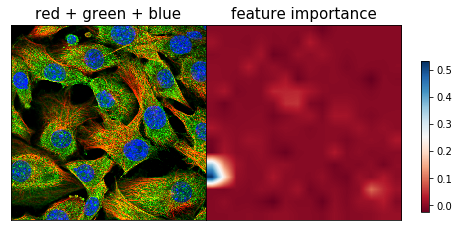

In [166]:
viz.viz_channels_combined(test_image, img_index, cv2.resize(rel_scores.numpy()[0,:,:,2], (1024,1024)))

In [167]:
# pkl.dump(rel_scores,open('./data/rel_scores_middle_sep_6','wb'))